In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath("")
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)

os.chdir("..")

In [2]:
import torch
from ot import wasserstein_1d
from scipy.stats import wasserstein_distance

In [3]:
a = torch.randn(10)
b = torch.randn(10)

d_ot = wasserstein_1d(a, b, p=1).item()
d_ot_2 = torch.sqrt(wasserstein_1d(a, b, p=2)).item()
d_scipy = wasserstein_distance(a, b)

## Time

In [13]:
%%timeit
d_ot = wasserstein_1d(a, b, p=1)

217 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
%%timeit
d_ot = wasserstein_1d(a.to("cuda"), b.to("cuda"), p=1)

494 µs ± 683 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
%%timeit
d_ot_2 = wasserstein_1d(a, b, p=2)

226 µs ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [15]:
%%timeit
d_scipy = wasserstein_distance(a, b)

46.3 µs ± 377 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [20]:
a = torch.randn(100)
b = torch.randn(100)

In [21]:
%%timeit
d_ot = wasserstein_1d(a, b, p=1)

239 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
%%timeit
d_ot_2 = wasserstein_1d(a, b, p=2)

250 µs ± 12 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [23]:
%%timeit
d_scipy = wasserstein_distance(a, b)

59.1 µs ± 845 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Graphs

In [53]:
import math

import matplotlib.pyplot as plt
import numpy as np
from torch.distributions.beta import Beta
from torch.distributions.normal import Normal
from tqdm.notebook import tqdm

In [31]:
mu_1 = 0.2
mu_2 = 0.8
sigma_1 = math.sqrt(0.1)
sigma_2 = math.sqrt(0.1)

dist_1 = Normal(mu_1, sigma_1)
dist_2 = Normal(mu_2, sigma_2)

wass_2_true = math.sqrt((mu_1 - mu_2) ** 2 + (sigma_1 - sigma_2) ** 2)
wass_2_true

0.6000000000000001

In [47]:
sample_size_list = np.arange(2, 1000, 4)
emp_wasserstein_1_list = []
emp_wasserstein_2_list = []

for sample_size in tqdm(sample_size_list):
    sample_1 = dist_1.sample((sample_size,))
    sample_2 = dist_2.sample((sample_size,))

    emp_wasserstein_2 = math.sqrt(wasserstein_1d(sample_1, sample_2, p=2))
    emp_wasserstein_2_list.append(emp_wasserstein_2)

    emp_wasserstein_1 = wasserstein_1d(sample_1, sample_2, p=1)
    emp_wasserstein_1_list.append(emp_wasserstein_1)

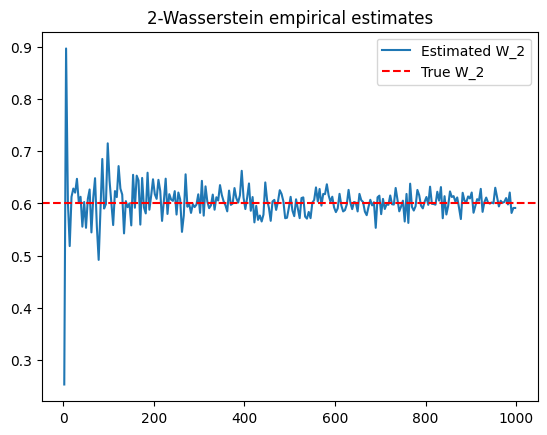

In [51]:
plt.plot(sample_size_list, emp_wasserstein_2_list, label="Estimated W_2")
# plt.plot(sample_size_list, emp_wasserstein_1_list, label="Estimated W_1")
plt.axhline(wass_2_true, c="red", linestyle="--", label="True W_2")
plt.title("2-Wasserstein empirical estimates")
plt.legend()
plt.show()

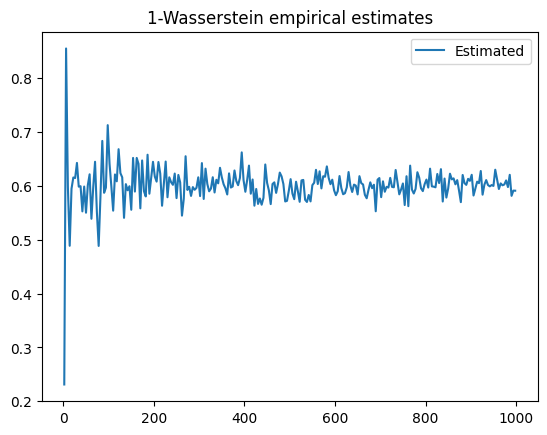

In [52]:
plt.plot(sample_size_list, emp_wasserstein_1_list, label="Estimated")
# plt.axhline(wass_1_true, c="red", linestyle="--", label="True")
plt.title("1-Wasserstein empirical estimates")
plt.legend()
plt.show()

In [69]:
alpha_1 = 1
beta_1 = 5

alpha_2 = 30
beta_2 = 20

dist_1 = Beta(alpha_1, beta_1)
dist_2 = Beta(alpha_2, beta_2)

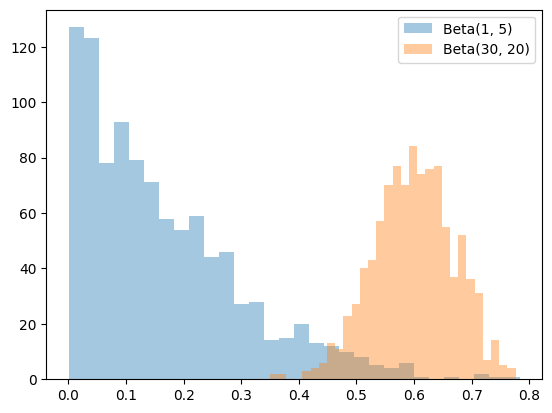

In [70]:
sample_1 = dist_1.sample((1000,))
sample_2 = dist_2.sample((1000,))

plt.hist(sample_1, bins=30, alpha=0.4, label=f"Beta({alpha_1}, {beta_1})")
plt.hist(sample_2, bins=30, alpha=0.4, label=f"Beta({alpha_2}, {beta_2})")
plt.legend()
plt.show()

In [71]:
sample_size_list = np.arange(2, 1000, 4)
emp_wasserstein_1_list = []
emp_wasserstein_2_list = []

for sample_size in tqdm(sample_size_list):
    sample_1 = dist_1.sample((sample_size,))
    sample_2 = dist_2.sample((sample_size,))

    emp_wasserstein_2 = math.sqrt(wasserstein_1d(sample_1, sample_2, p=2))
    emp_wasserstein_2_list.append(emp_wasserstein_2)

    emp_wasserstein_1 = wasserstein_1d(sample_1, sample_2, p=1)
    emp_wasserstein_1_list.append(emp_wasserstein_1)

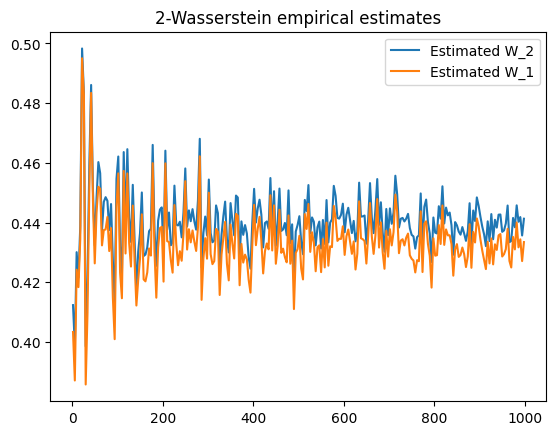

In [72]:
plt.plot(sample_size_list, emp_wasserstein_2_list, label="Estimated W_2")
plt.plot(sample_size_list, emp_wasserstein_1_list, label="Estimated W_1")
plt.title("2-Wasserstein empirical estimates")
plt.legend()
plt.show()

# Check metrics

In [4]:
import numpy as np
import torch
import yaml
from src.datasets.datasets import CPDDatasets
from src.ensembles.ensembles import EnsembleCPDModel
from src.metrics.evaluation_pipelines import (
    all_distances_evaluation_pipeline,
)
from src.utils.fix_seeds import fix_seeds
from torch.utils.data import DataLoader

SEED = 42
fix_seeds(SEED)

%load_ext autoreload
%autoreload
%matplotlib inline

comet_ml is installed but `COMET_API_KEY` is not set.


In [8]:
model_type = "seq2seq"

experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [9]:
path_to_models_folder = "saved_models/bce/human_activity/full_sample/ens_1"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

In [5]:
# wasserstein-2
threshold_list = np.linspace(0, 1, 100)

res_dist = all_distances_evaluation_pipeline(
    ens_bce,
    test_dataloader,
    distance="wasserstein_1d",
    p=2,
    device="cpu",
    verbose=True,
    window_size_list=[1, 2, 3],
    margin_list=[1, 2, 4],
    anchor_window_type_list=["start", "prev"],
    threshold_list=threshold_list,
)

 10%|▉         | 2/21 [00:00<00:01, 17.64it/s]

Collectting model's outputs


  0%|          | 0/100 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.4444444444444445
AUDC: 0.0, Time to FA: 11.1563, DD: 1.0718, F1: 0.9727, Cover: 0.9132, Max Cover: 0.9132
Max F1 with margin 1: 0.9636
Max F1 with margin 2: 0.9673
Max F1 with margin 4: 0.97
window_size = 1, anchor_window_type = prev


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.393939393939394
AUDC: 0.0, Time to FA: 11.3388, DD: 1.1653, F1: 0.9736, Cover: 0.918, Max Cover: 0.918
Max F1 with margin 1: 0.9691
Max F1 with margin 2: 0.9722
Max F1 with margin 4: 0.9727
window_size = 2, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.3434343434343435
AUDC: 0.0, Time to FA: 11.1264, DD: 1.083, F1: 0.975, Cover: 0.9114, Max Cover: 0.9114
Max F1 with margin 1: 0.9454
Max F1 with margin 2: 0.9673
Max F1 with margin 4: 0.9705
window_size = 2, anchor_window_type = prev


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.26262626262626265
AUDC: 0.0, Time to FA: 11.0927, DD: 1.0598, F1: 0.975, Cover: 0.9125, Max Cover: 0.9125
Max F1 with margin 1: 0.952
Max F1 with margin 2: 0.9678
Max F1 with margin 4: 0.9719
window_size = 3, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.32323232323232326
AUDC: 0.0, Time to FA: 11.1975, DD: 1.1907, F1: 0.9741, Cover: 0.9069, Max Cover: 0.9069
Max F1 with margin 1: 0.9211
Max F1 with margin 2: 0.953
Max F1 with margin 4: 0.9687
window_size = 3, anchor_window_type = prev


100%|██████████| 100/100 [07:00<00:00,  4.21s/it]

Results for best threshold = 0.27272727272727276
AUDC: 0.0, Time to FA: 11.2229, DD: 1.1638, F1: 0.9759, Cover: 0.9106, Max Cover: 0.9106
Max F1 with margin 1: 0.9362
Max F1 with margin 2: 0.9557
Max F1 with margin 4: 0.9704


# Explosions

In [5]:
model_type = "seq2seq"

experiments_name = "explosion"

path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"

with open(path_to_config, "r") as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2

train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
test_dataloader = DataLoader(
    test_dataset, batch_size=args_config["learning"]["batch_size"], shuffle=False
)

In [6]:
path_to_models_folder = (
    "saved_models/bce/explosion/layer_norm/train_anomaly_num_155/ens_1"
)

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

In [7]:
# wasserstein-2
threshold_list = np.linspace(0, 1, 100)

res_dist = all_distances_evaluation_pipeline(
    ens_bce,
    test_dataloader,
    distance="wasserstein_1d",
    p=2,
    device="cuda",
    verbose=True,
    window_size_list=[1, 2, 3],
    margin_list=[1, 2, 4],
    anchor_window_type_list=["start", "prev"],
    threshold_list=threshold_list,
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


  0%|          | 0/100 [00:00<?, ?it/s]

window_size = 1, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.696969696969697
AUDC: 0.0, Time to FA: 15.7714, DD: 0.2095, F1: 0.75, Cover: 0.9837, Max Cover: 0.9837
Max F1 with margin 1: 0.125
Max F1 with margin 2: 0.5714
Max F1 with margin 4: 0.6364
window_size = 1, anchor_window_type = prev


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.21212121212121213
AUDC: 0.0, Time to FA: 15.6571, DD: 0.1175, F1: 0.7143, Cover: 0.9877, Max Cover: 0.9877
Max F1 with margin 1: 0.56
Max F1 with margin 2: 0.6154
Max F1 with margin 4: 0.7143
window_size = 2, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.6565656565656566
AUDC: 0.0, Time to FA: 15.7778, DD: 0.2127, F1: 0.6957, Cover: 0.9832, Max Cover: 0.9832
Max F1 with margin 1: 0.0
Max F1 with margin 2: 0.4211
Max F1 with margin 4: 0.5714
window_size = 2, anchor_window_type = prev


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.27272727272727276
AUDC: 0.0, Time to FA: 15.619, DD: 0.1206, F1: 0.7586, Cover: 0.9856, Max Cover: 0.9856
Max F1 with margin 1: 0.56
Max F1 with margin 2: 0.6154
Max F1 with margin 4: 0.7586
window_size = 3, anchor_window_type = start


  0%|          | 0/100 [00:00<?, ?it/s]

Results for best threshold = 0.4646464646464647
AUDC: 0.0, Time to FA: 15.5683, DD: 0.1524, F1: 0.6857, Cover: 0.9797, Max Cover: 0.9797
Max F1 with margin 1: 0.0833
Max F1 with margin 2: 0.4667
Max F1 with margin 4: 0.6061
window_size = 3, anchor_window_type = prev


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]

Results for best threshold = 0.29292929292929293
AUDC: 0.0, Time to FA: 15.6286, DD: 0.1302, F1: 0.7586, Cover: 0.9846, Max Cover: 0.9846
Max F1 with margin 1: 0.4348
Max F1 with margin 2: 0.6154
Max F1 with margin 4: 0.8
